### Importing required modules

In [1]:
import os
import importlib

import pandas as pd
import numpy as np
import seaborn as sns

In [62]:
from utils import preprocessing, io_files, plot_utils

importlib.reload(preprocessing)
importlib.reload(plot_utils)
_ = importlib.reload(io_files)

### Importing dataset file and loading the data.

In [3]:
dataset_file = "dataset/archive/AB_NYC_2019.csv"

In [4]:
df0 = pd.read_csv(dataset_file)
df0.head()


print("Dataset size:\n"
      f"\trows: {df0.shape[0]}\n"
      f"\tcolumns: {df0.shape[1]}")

Dataset size:
	rows: 48895
	columns: 16


In [5]:
display(df0.columns.tolist())

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [6]:
preprocessing.drop_irrelevant_cols(df0)
missing_data_info_df = preprocessing.find_missing_data_freq(df0)
display(missing_data_info_df)

,Missing Data,% of Missing Data
last_review,10052,20.56
reviews_per_month,10052,20.56


## Step 1: Cleaning and Pre-Processing data for further analysis

### Finding Missing data for last_review or reviews_per_month

In [7]:
# rows with missing last-review and reviews per month
df_missing_data = df0[df0.last_review.isna() | df0.reviews_per_month.isna()]

display(df_missing_data.head())

print("Missing data rows:", df_missing_data.shape[0])

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
19,7750,17985,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,NaN,2,249
26,8700,26394,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,NaN,1,0
36,11452,7355,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,NaN,1,365
38,11943,45445,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaN,NaN,1,365


Missing data rows: 10052


We can see that there are **10,000+ rows** that have missing data.

The information of `last_review` or `reviews_per_month` is very important to determine the popularity or activity of certain listing.
\
So, we need to device a way to trim out those hosts that are least active and are going to do minimal contribution to the model.

In [8]:
unique_missing_data_hostid = df_missing_data.host_id.unique().tolist()
print(len(unique_missing_data_hostid), "unique hosts having missing missing information.")

8238 unique hosts having missing missing information.


Thus, `8238` hosts are _unique_ rest of the hosts from `10,052` listing hosts are _duplicate_.
\
This means, there're around 2k+ hosts that have repeated missing information about `last_review_date` or `reviews_per_month` data.

So, we are tring to find the ratio of $\frac{missing}{non-missing}$ data for each of those `8238` hosts.

In [9]:
# rows having host_id from unique_missing_data_hostid and their number of missing data rows/ number of non-missing data rows
rows_missing_last_review_reviews_per_month = df0[df0.host_id.isin(unique_missing_data_hostid)]
rows_missing_last_review_reviews_per_month.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
19,7750,17985,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,NaN,2,249
26,8700,26394,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,NaN,1,0
28,9518,31374,Manhattan,Inwood,40.86482,-73.92106,Private room,44,3,108,2019-06-15,1.11,3,311
36,11452,7355,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,NaN,1,365


In [10]:
io_files.export_as_csv(rows_missing_last_review_reviews_per_month, filename="Missing-review-info-hostid-collection.csv")

PosixPath('/media/tuhin/hdd/Documents/All_Python_Resources/AirBNB_DataAnalysis/utils/tmp/Missing-review-info-hostid-collection.csv')

### Finding the information about missing/non-missing review data information.

Using this information, we can exclude certain hosts that have mostly missing data and can negatively affect the model prediction.
\
As per the calculation, above we will get 8238 rows of host id information that have **atleast one missing data row.**

The criteria for considering one missing data row is: **Either of the following condition has to satisfy**:
1. `number_of_reviews` must be `0` or `None/NaN`
2. `reviews_per_month` has to be `0` or `None/NaN`
3. `last_review` has to be `NaN`

In [11]:
df_host_missing_review = preprocessing.find_host_missing_review_data(df0)
df_host_missing_review.loc[df_host_missing_review.missing_review_count != 0, :]

,host_id,missing_review_count,non_missing_review_count,missing_review_percent
2,4632,1,0,100.000000
19,17985,1,1,50.000000
24,26394,1,0,100.000000
26,31374,1,2,33.333333
32,7355,1,0,100.000000
...,...,...,...,...
37452,274307600,1,0,100.000000
37453,274311461,1,0,100.000000
37454,274321313,1,0,100.000000
37455,23492952,1,0,100.000000


In [12]:
df_host_missing_review[df_host_missing_review.missing_review_percent >= 30].shape[0]

8068

From above calculation, we can see that there are **`8068` rows/hosts** that contain **`30% <=`** amount of their data **missing review information**

### Cleaning irrelevant data rows (based on review information missing)

As calculated in the above section, that around `30%` of the hosts are missing their **last review date**, **reviews per month** or **number of reviews** information. These parameters are important to decide what is the activity of perticular hosts. Based on that, we tracked out all the `host ids` and the information related to how much amout of data they are missing.

Based on the assumption that if more than `30%` data of some hosts are missing, we can remove all the listing information for that particular `host id`.

**Cleaning out hosts that contain more than or equal to 30% of their data missing.**

In [13]:
to_remove_host_ids = df_host_missing_review[df_host_missing_review.missing_review_percent >= 30].host_id.unique()

print(f"{len(to_remove_host_ids)} hosts to remove from the dataset.")

8068 hosts to remove from the dataset.


In [14]:
rows_to_remove = df0[df0.host_id.isin(to_remove_host_ids)]

print(f"{rows_to_remove.shape[0]} rows will be dropped from the dataset.")

11649 rows will be dropped from the dataset.


In [15]:
df01 = df0.copy()
df01.drop(rows_to_remove.index, axis=0, inplace=True)

print(f"Dataset new length: {df01.shape[0]}")

Dataset new length: 37246


**11,649 rows have been removed from the dataset. With 30% as the threshold limit for the missing percent of review information.**

## Step 2: Data Exploratory Analysis

### A. What is the price distribution across different neighbouring groups in NYC ?

<Axes: xlabel='neighbourhood_group', ylabel='price'>

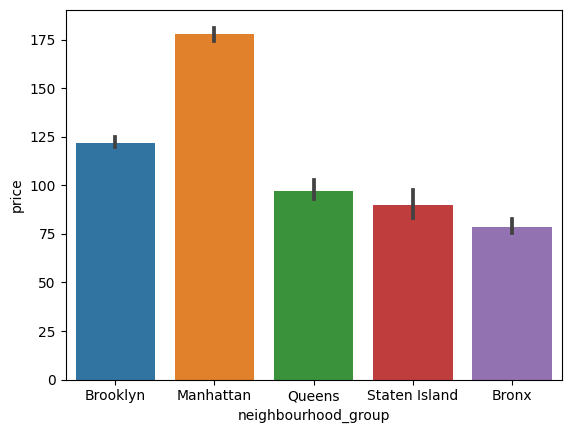

In [16]:
sns.barplot(df01, x='neighbourhood_group', y='price')

The above distribution shows that Manhattan has the highest priced listing as per the data. While Brooklyn ranks the second most costly place.

### B. What proportion of rentals correspond to each room type?

**Interactive visualization to find proportion of each room type booked in a particular neighbourhood group**

In [17]:
import ipywidgets as widgets
from IPython.display import clear_output
from matplotlib import pyplot as plt

dropdown = widgets.Dropdown(
    options = df0.neighbourhood_group.unique(),
    value = df0.neighbourhood_group.unique()[0],
    description = "Select Neighbourhood:",
    disabled = False
)

def formatter_func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"


def plot_pie_chart(selected_nb_str: str):
    nb_selected_rt_data = df01.loc[df01.neighbourhood_group == selected_nb_str, 'room_type']
    data = nb_selected_rt_data.value_counts(normalize=True) * 100

    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: formatter_func(pct, data),
                                      textprops=dict(color="w"))

    ax.legend(wedges, nb_selected_rt_data.unique(),
              title="Neighbourhood Groups",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")
    ax.set_title(selected_nb_str)
    plt.show()


def change_handler(selected_nb_group: str):
    if selected_nb_group.type == "change" and type(selected_nb_group.new) == int:
        
        clear_output(wait=True)
        selected_nb_str = selected_nb_group.owner.value
        
        plot_pie_chart(selected_nb_str)
        
        display(dropdown)

dropdown.observe(change_handler)

display(dropdown)

Dropdown(description='Select Neighbourhood:', options=('Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Br…

From the interactive plot above we can see the proportions rentals booked corresponding to each neighbourhood group (viz. Brooklyn, Manhattan, Queens, Staten Island, Bronx).

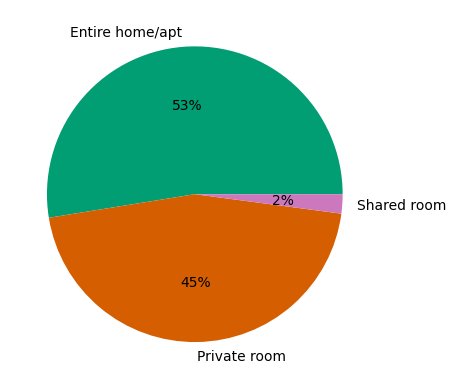

In [18]:
colors = sns.color_palette('colorblind')[2:5]
plt.pie(df01.room_type.value_counts(), labels=df01.room_type.value_counts().index, colors=colors, autopct="%0.0f%%")
plt.show()

In [19]:
df01.room_type.value_counts()

room_type
Entire home/apt    19573
Private room       16889
Shared room          784
Name: count, dtype: int64

When we do an overall analysis on the data, it seems `53%` of the rentals (`19,573`) have opted for **Entire home/apt**, while `45%` (`16,889`) opted for **Private rooms**, and the rest **shared room** with around `2%` of the total bookings

### C. How much average price difference is there between different room types?

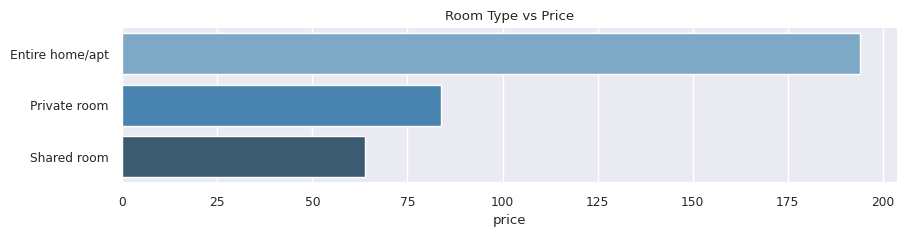

In [69]:
_ = plot_utils.plot_hbar_plot(df01.groupby('room_type').price.mean(), "Room Type vs Price", figsize=(10, 2))

In [78]:
price_mean_series = df01.groupby('room_type').price.mean().sort_values()
(price_mean_series.diff() * (100 / price_mean_series.values.min())).round(2)

room_type
Shared room           NaN
Private room        31.27
Entire home/apt    172.44
Name: price, dtype: float64

**Shared room** have the lowest price, while **Private rooms** are `~31%` costlier than shared room, while **Entire home/apt** are `172.44%` costlier than shared room _(avg. minimum price)_.